In [1]:
import h5py
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tinygrad.tensor import Tensor

In [2]:
np.set_printoptions(precision=6, suppress=True, threshold=50)  # Adjust precision & display settings


In [12]:
photon_file= h5py.File('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5','r')
electron_file= h5py.File('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5','r')
x_photon=np.array(photon_file['X'][:], dtype=np.float32)
y_photon=np.array(photon_file['y'][:], dtype=np.float32)
x_electron=np.array(electron_file['X'][:], dtype=np.float32)
y_electron=np.array(electron_file['y'][:], dtype=np.float32)
photon_file.close()
electron_file.close()


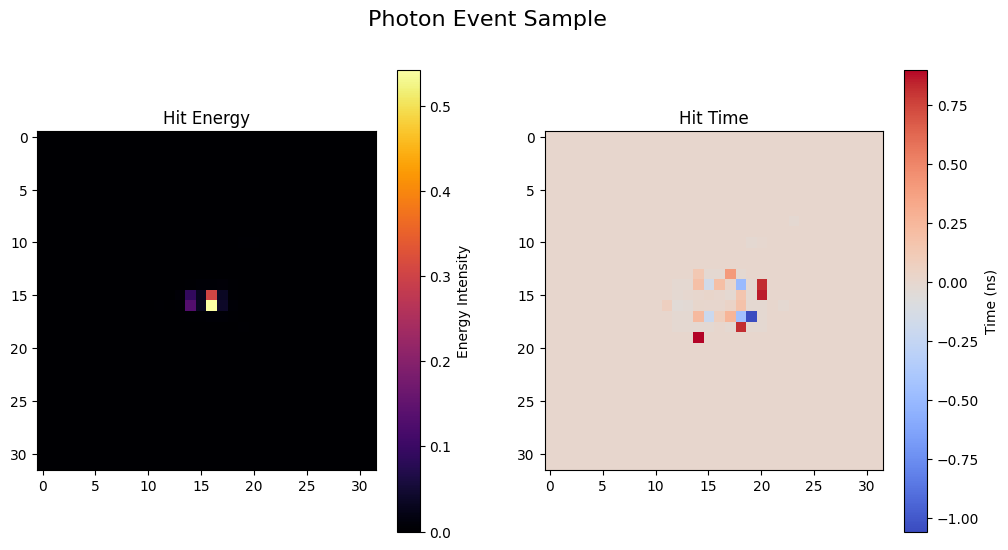

In [5]:
sample_idx = 0
image =x_photon[sample_idx]  # Shape: (32, 32, 2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Photon Event Sample", fontsize=16)
# Plot Hit Energy
im1 = axes[0].imshow(image[:, :, 0], cmap="inferno")
axes[0].set_title("Hit Energy")
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label("Energy Intensity")

# Plot Hit Time
im2 = axes[1].imshow(image[:, :, 1], cmap="coolwarm")
axes[1].set_title("Hit Time")
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label("Time (ns)")

plt.show()


In [6]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (398400, 32, 32, 2)
y_train shape: (398400, 1)
X_test shape: (99600, 32, 32, 2)
y_test shape: (99600, 1)


In [ ]:
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tinygrad.tensor import Tensor
from tinygrad.nn.state import get_parameters
from tinygrad.nn import optim, Conv2d
from extra.models.resnet import ResNet

Tensor.training = True


# Custom ResNet definition for 2 input channels
class ResNet2Channel(ResNet):
    def __init__(self, num, num_classes):
        super().__init__(num, num_classes)
        self.conv1 = Conv2d(2, 64, kernel_size=7, stride=2, padding=3)

# Data Generator 
class DataGenerator:
    def __init__(self, file_path, batch_size=32, is_train=True, test_split=0.2, random_state=42):
        self.file_path = file_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.test_split = test_split
        self.random_state = random_state
        self.file = None
        self.indices = None
        self.n_samples = None
        self._init_dataset()
        
    def _init_dataset(self):
        self.file = h5py.File(self.file_path, 'r')
        self.n_samples = self.file['X'].shape[0]
        
        # Create train/test split indices
        all_indices = np.arange(self.n_samples)
        train_indices, test_indices = train_test_split(
            all_indices, test_size=self.test_split, random_state=self.random_state
        )
        
        # Select appropriate indices
        self.indices = train_indices if self.is_train else test_indices
        np.random.shuffle(self.indices)
        
        self.n_samples = len(self.indices)
        self.current_position = 0
        
    def __len__(self):
        return int(np.ceil(self.n_samples / self.batch_size))
    
    def __iter__(self):
        self.current_position = 0
        np.random.shuffle(self.indices)
        return self
    
    def __next__(self):
        if self.current_position >= self.n_samples:
            raise StopIteration
            
        # Get batch indices and make sure they're sorted for HDF5 indexing
        batch_indices = self.indices[self.current_position:self.current_position + self.batch_size]
        sorted_indices_args = np.argsort(batch_indices)  # Get sorting order
        sorted_batch_indices = batch_indices[sorted_indices_args]  # Sort indices
        
        self.current_position += self.batch_size
        
        # Load the batch data in sorted order
        X_batch = self.file['X'][sorted_batch_indices].astype(np.float32)
        y_batch = self.file['y'][sorted_batch_indices].astype(np.float32)
        
        # If needed, restore the original random order (optional)
        if len(sorted_indices_args) > 0:  # Check if we have enough samples
            X_batch = X_batch[np.argsort(sorted_indices_args)]
            y_batch = y_batch[np.argsort(sorted_indices_args)]
        
        # Preprocess the data
        X_batch = X_batch / np.max(X_batch)  # Normalize to [0, 1]
        y_batch = np.expand_dims(y_batch, axis=1)
        
        return Tensor(X_batch), Tensor(y_batch)
    
    def close(self):
        if self.file is not None:
            self.file.close()

# Alternative approach using a simpler batch function to avoid indexing issues
def batch_loader(file_path, batch_size=32, is_training=True):
    """Simple function to load and process batches without complex indexing"""
    with h5py.File(file_path, 'r') as f:
        total_samples = f['X'].shape[0]
        
        # Create a train/test split
        indices = np.arange(total_samples)
        train_size = int(0.8 * total_samples)
        
        if is_training:
            subset_indices = indices[:train_size]
        else:
            subset_indices = indices[train_size:]
            
        np.random.shuffle(subset_indices)
        
        # Process in sequential batches to avoid indexing issues
        for i in range(0, len(subset_indices), batch_size):
            # Get current batch indices
            current_indices = subset_indices[i:i+batch_size]
            
            # Load batch data one sample at a time to avoid indexing issues
            X_batch = []
            y_batch = []
            
            for idx in current_indices:
                X_batch.append(f['X'][idx])
                y_batch.append(f['y'][idx])
                
            X_batch = np.array(X_batch, dtype=np.float32)
            y_batch = np.array(y_batch, dtype=np.float32)
            
            # Preprocess
            X_batch = X_batch / 255.0  # Normalize
            X_batch = np.transpose(X_batch, (0, 3, 1, 2))  # Convert to channel-first format
            y_batch = np.expand_dims(y_batch, axis=1)
            
            yield Tensor(X_batch), Tensor(y_batch)

# Main training function to work with the batch loader
def train_with_batch_loader():
    # Initialize model
    model = ResNet2Channel(18, num_classes=1)  # Binary classification
    optimizer = optim.SGD(get_parameters(model), lr=1e-3, momentum=0.9)
    
    # Training parameters
    epochs = 5
    
    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1}/{epochs}")
        
        # Train with photon data
        total_loss = 0
        batches = 0
        
        # Alternate between photon and electron batches
        for i, ((X_photon, y_photon), (X_electron, y_electron)) in enumerate(
            zip(batch_loader('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', batch_size=8), 
                batch_loader('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', batch_size=8))):
            
            # Train on photon batch
            out_photon = model.forward(X_photon)
            loss_photon = ((out_photon - y_photon) ** 2).mean()
            
            # Train on electron batch
            out_electron = model.forward(X_electron)
            loss_electron = ((out_electron - y_electron) ** 2).mean()
            
            # Combined loss
            loss = loss_photon + loss_electron
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.numpy()
            batches += 1
            
            # Force cleanup
            import gc
            gc.collect()
            
            # Print progress
            if i % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.numpy()}")
                
            # Break early for debugging
            if i >= 100:  # Process only 100 batches per epoch for debugging
                break
        
        avg_loss = total_loss / batches
        print(f"Epoch {epoch+1} completed - Average Loss: {avg_loss}")

def train_simplified():
    """Simplified approach loading entire files into memory but processing in batches"""
    # Load data (consider directly loading with numpy if HDF5 causes issues)
    print("Loading photon data...")
    with h5py.File('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
        x_photon = np.array(f['X'][:10000], dtype=np.float32)  # Limit to first 10k samples to save memory
        y_photon = np.array(f['y'][:10000], dtype=np.float32)
    
    print("Loading electron data...")
    with h5py.File('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
        x_electron = np.array(f['X'][:10000], dtype=np.float32)  # Limit to first 10k samples 
        y_electron = np.array(f['y'][:10000], dtype=np.float32)
    
    print("Preparing data...")
    # Combine the data
    X = np.concatenate((x_photon, x_electron))
    Y = np.concatenate((y_photon, y_electron))
    Y = np.expand_dims(Y, axis=1)
    
    # Free memory
    del x_photon, x_electron, y_photon, y_electron
    import gc
    gc.collect()
    
    # Split into train/test
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    train_size = int(0.8 * len(indices))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Initialize model
    print("Initializing model...")
    model = ResNet2Channel(18, num_classes=1)
    optimizer = optim.SGD(get_parameters(model), lr=5e-4, momentum=0.9)
    
    # Training parameters
    epochs = 5
    batch_size = 8
    
    print("Starting training...")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        np.random.shuffle(train_indices)
        total_loss = 0
        batches = 0
        
        # Process in batches
        for i in range(0, len(train_indices), batch_size):
            batch_idx = train_indices[i:i+batch_size]
            X_batch = X[batch_idx]
            Y_batch = Y[batch_idx]
            
            # Preprocess
            X_batch = X_batch / 255.0
            X_batch = np.transpose(X_batch, (0, 3, 1, 2))  # NHWC -> NCHW format
            
            # Convert to tensors
            X_tensor = Tensor(X_batch)
            Y_tensor = Tensor(Y_batch)
            
            # Forward pass
            out = model.forward(X_tensor)
            loss = ((out - Y_tensor) ** 2).mean()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.numpy()
            batches += 1
            
            if i % 50 == 0:
                print(f"  Batch {i//batch_size}/{len(train_indices)//batch_size}, Loss: {loss.numpy()}")
            
            # Force cleanup
            del X_tensor, Y_tensor, out, loss
            gc.collect()
        
        avg_loss = total_loss / batches
        print(f"Epoch {epoch+1} completed - Average Loss: {avg_loss}")
        
        # Validation
        val_loss = 0
        val_batches = 0
        
        # Process only a few validation batches to save memory
        for i in range(0, min(len(test_indices), 500), batch_size):
            batch_idx = test_indices[i:i+batch_size]
            X_batch = X[batch_idx]
            Y_batch = Y[batch_idx]
            
            # Preprocess
            X_batch = X_batch / 255.0
            X_batch = np.transpose(X_batch, (0, 3, 1, 2))
            
            # Convert to tensors
            X_tensor = Tensor(X_batch)
            Y_tensor = Tensor(Y_batch)
            
            # Forward pass only
            out = model.forward(X_tensor)
            val_batch_loss = ((out - Y_tensor) ** 2).mean().numpy()
            
            val_loss += val_batch_loss
            val_batches += 1
            
            # Cleanup
            del X_tensor, Y_tensor, out
            gc.collect()
        
        val_avg_loss = val_loss / val_batches
        print(f"Validation Loss: {val_avg_loss}")

if __name__ == "__main__":
    # Choose one approach based on your system constraints
    # train_with_batch_loader()  # Uses the generator approach
    # train_simplified()  # Uses the simplified approach